In [1]:
from pathlib import Path
import glob
import exiftool
import soundfile as sf

In [2]:
import numpy as np
import scipy
import pandas as pd
import dask.dataframe as dd
import librosa

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt
import pytz
from tqdm import tqdm
from sklearn.cluster import KMeans
import scipy

In [4]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from cfg import get_config
from pipeline import pipeline
from utils.utils import gen_empty_df, convert_df_ravenpro

In [32]:
LABEL_FOR_GROUPS = {
                    0: 'LF', 
                    1: 'HF'
                    }

In [5]:
def plot_audio_seg(audio_features, spec_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()


def plot_dets_over_audio(audio_features, spec_features, plot_dets):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)

    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()

In [6]:
def generate_segments(audio_file: Path, output_dir: Path, start_time: float, duration: float):
    """
    Segments audio file into clips of duration length and saves them to output/tmp folder.
    Allows detection model to be run on segments instead of entire file as recommended.
    These segments will be deleted from the output/tmp folder after detections have been generated.

    Parameters
    ------------
    audio_file : `pathlib.Path`
        - The path to an audio_file from the input directory provided in the command line
    output_dir : `pathlib.Path`
        - The path to the tmp folder that saves all of our segments.
    start_time : `float`
        - The time at which the segments will start being generated from within the audio file
    duration : `float`
        - The duration of all segments generated from the audio file.

    Returns
    ------------
    output_files : `List`
        - The path (a str) to each generated segment of the given audio file will be stored in this list.
        - The offset of each generated segment of the given audio file will be stored in this list.
        - Both items are stored in a dict{} for each generated segment.
    """
    
    ip_audio = sf.SoundFile(audio_file)

    sampling_rate = ip_audio.samplerate
    # Convert to sampled units
    ip_start = int(start_time * sampling_rate)
    ip_duration = int(duration * sampling_rate)
    ip_end = ip_audio.frames

    output_files = []

    # for the length of the duration, process the audio into duration length clips
    for sub_start in range(ip_start, ip_end, ip_duration):
        sub_end = np.minimum(sub_start + ip_duration, ip_end)

        # For file names, convert back to seconds 
        op_file = audio_file.name.replace(" ", "_")
        start_seconds =  sub_start / sampling_rate
        end_seconds =  sub_end / sampling_rate
        op_file_en = "__{:.2f}".format(start_seconds) + "_" + "{:.2f}".format(end_seconds)
        op_file = op_file[:-4] + op_file_en + ".wav"
        
        op_path = output_dir / op_file
        output_files.append({
            "input_filepath": audio_file,
            "audio_file": op_path, 
            "offset":  start_time + (sub_start/sampling_rate),
        })
        
        if (not(op_path.exists())):
            sub_length = sub_end - sub_start
            ip_audio.seek(sub_start)
            op_audio = ip_audio.read(sub_length)
            sf.write(op_path, op_audio, sampling_rate, subtype='PCM_16')

    return output_files 

def generate_segmented_paths(audio_files, cfg):
    """
    Generates and returns a list of segments using provided cfg parameters for each audio file in audio_files.

    Parameters
    ------------
    audio_files : `List`
        - List of pathlib.Path objects of the paths to each audio file in the provided input directory.
    cfg : `dict`
        - A dictionary of pipeline parameters:
        - tmp_dir is the directory where segments will be stored
        - start_time is the time at which segments are generated from each audio file.
        - segment_duration is the duration of each generated segment

    Returns
    ------------
    segmented_file_paths : `List`
        - A list of dictionaries related to every generated segment.
        - Each dictionary stores a generated segment's path in the tmp_dir and offset in the original audio file.
    """

    segmented_file_paths = []
    for audio_file in audio_files:
        segmented_file_paths += generate_segments(
            audio_file = audio_file, 
            output_dir = cfg['tmp_dir'],
            start_time = cfg['start_time'],
            duration   = cfg['segment_duration'],
        )
    return segmented_file_paths


def initialize_mappings(necessary_paths, cfg):
    """
    Generates and returns a list of mappings using provided cfg parameters for each audio segment in the provided necessary paths.

    Parameters
    ------------
    necessary_paths : `List`
        - List of dictionaries generated by generate_segmented_paths()
    cfg : `dict`
        - A dictionary of pipeline parameters:
        - models is the models in the pipeline that are being used.

    Returns
    ------------
    l_for_mapping : `List`
        - A list of dictionaries related to every generated segment with more pipeline details.
        - Each dictionary stores the prior segmented_path dict{}, the model to apply, and the original file name of the segment.
    """

    l_for_mapping = [{
        'audio_seg': audio_seg, 
        'model': cfg['models'][0],
        'original_file_name': audio_seg["input_filepath"],
        } for audio_seg in necessary_paths]

    return l_for_mapping

In [47]:
def get_section_of_call_in_file(detection, audio_file):
    fs = audio_file.samplerate

    call_dur = (detection['end_time'] - detection['start_time'])
    pad = min(min(detection['start_time'] - call_dur, 1795 - detection['end_time']), 0.006) / 3
    start = detection['start_time'] - call_dur - (3*pad)
    duration = (2 * call_dur) + (4*pad)

    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))

    length_of_section = call_dur + (2*pad)

    return audio_seg, length_of_section

def get_snr_from_band_limited_signal(snr_call_signal, snr_noise_signal): 
    signal_power_rms = np.sqrt(np.square(snr_call_signal).mean())
    noise_power_rms = np.sqrt(np.square(snr_noise_signal).mean())
    snr = abs(20 * np.log10(signal_power_rms / noise_power_rms))
    return snr


def bandpass_audio_signal(audio_seg, fs, low_freq_cutoff, high_freq_cutoff):
    nyq = fs // 2
    low_cutoff = (low_freq_cutoff) / nyq
    high_cutoff =  (high_freq_cutoff) / nyq
    b, a = scipy.signal.butter(4, [low_cutoff, high_cutoff], btype='band', analog=False)
    band_limited_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)

    return band_limited_audio_seg

def compute_welch_psd_of_call(call, fs, audio_info):
    freqs, welch = scipy.signal.welch(call, fs=fs, detrend=False, scaling='spectrum')
    cropped_welch = welch[(freqs<=audio_info['max_freq_visible'])]
    audio_spectrum_mag = np.abs(cropped_welch)
    audio_spectrum_db =  10*np.log10(audio_spectrum_mag)
    normalized_audio_spectrum_db = audio_spectrum_db - audio_spectrum_db.max()

    thresh = -100
    peak_db = np.zeros(len(normalized_audio_spectrum_db))+thresh
    peak_db[normalized_audio_spectrum_db>=thresh] = normalized_audio_spectrum_db[normalized_audio_spectrum_db>=thresh]

    original_freq_vector = np.arange(0, len(peak_db), 1).astype('int')
    common_freq_vector = np.linspace(0, len(peak_db)-1, audio_info['num_points']).astype('int')
    interp_kind = 'linear'
    interpolated_points_from_welch = scipy.interpolate.interp1d(original_freq_vector, peak_db, kind=interp_kind)(common_freq_vector)

    return interpolated_points_from_welch

def gather_features_of_interest(dets, kmean_welch, audio_file):
    fs = audio_file.samplerate
    features_of_interest = dict()
    features_of_interest['call_signals'] = []
    features_of_interest['welch_signals'] = []
    features_of_interest['snrs'] = []
    features_of_interest['peak_freqs'] = []
    features_of_interest['classes'] = []
    nyquist = fs//2
    for index, row in dets.iterrows():
        audio_seg, length_of_section = get_section_of_call_in_file(row, audio_file)
        
        freq_pad = 2000
        low_freq_cutoff = row['low_freq']-freq_pad
        high_freq_cutoff = min(nyquist-1, row['high_freq']+freq_pad)
        band_limited_audio_seg = bandpass_audio_signal(audio_seg, fs, low_freq_cutoff, high_freq_cutoff)

        signal = band_limited_audio_seg.copy()
        signal[:int(fs*(length_of_section))] = 0
        noise = band_limited_audio_seg - signal
        snr_call_signal = signal[-int(fs*length_of_section):]
        snr_noise_signal = noise[:int(fs*length_of_section)]
        features_of_interest['call_signals'].append(snr_call_signal)

        snr = get_snr_from_band_limited_signal(snr_call_signal, snr_noise_signal)
        features_of_interest['snrs'].append(snr)

        welch_info = dict()
        welch_info['num_points'] = 100
        max_visible_frequency = 96000
        welch_info['max_freq_visible'] = max_visible_frequency
        welch_signal = compute_welch_psd_of_call(snr_call_signal, fs, welch_info)
        features_of_interest['welch_signals'].append(welch_signal)

        peaks = np.where(welch_signal==max(welch_signal))[0][0]
        features_of_interest['peak_freqs'].append((max_visible_frequency/len(welch_signal))*peaks)
        
        welch_signal = (welch_signal).reshape(1, len(welch_signal))
        features_of_interest['classes'].append(kmean_welch.predict(welch_signal)[0])

    features_of_interest['call_signals'] = np.array(features_of_interest['call_signals'], dtype='object')

    return features_of_interest


def open_and_get_call_info(audio_file, dets):
    welch_key = 'all_locations'
    output_dir = Path(f'../../duty-cycle-investigation/data/generated_welch/{welch_key}')
    output_file_type = 'top1_inbouts_welch_signals'
    welch_data = pd.read_csv(output_dir / f'2022_{welch_key}_{output_file_type}.csv', index_col=0, low_memory=False)
    k = 2
    kmean_welch = KMeans(n_clusters=k, n_init=10, random_state=1).fit(welch_data.values)

    features_of_interest = gather_features_of_interest(dets, kmean_welch, audio_file)

    dets.reset_index(drop=True, inplace=True)

    dets['sampling_rate'] = len(dets) * [audio_file.samplerate]
    dets.insert(0, 'SNR', features_of_interest['snrs'])
    dets.insert(0, 'peak_frequency', features_of_interest['peak_freqs'])
    dets.insert(0, 'KMEANS_CLASSES', pd.Series(features_of_interest['classes']).map(LABEL_FOR_GROUPS))

    return features_of_interest['call_signals'], dets

def classify_calls_from_file(bd2_predictions, data_params):
    file_path = Path(data_params['audio_file'])
    audio_file = sf.SoundFile(file_path)
    call_signals, dets = open_and_get_call_info(audio_file, bd2_predictions.copy())

    median_peak_HF_freq = dets[dets['KMEANS_CLASSES']=='HF']['peak_frequency'].median()
    median_peak_LF_freq = dets[dets['KMEANS_CLASSES']=='LF']['peak_frequency'].median()
    print(f'Median LF frequency in File: {median_peak_LF_freq}')
    print(f'Median HF frequency in File: {median_peak_HF_freq}')
    lf_inds = (dets['peak_frequency']<median_peak_LF_freq+7000)&(dets['peak_frequency']>median_peak_LF_freq-7000)
    hf_inds = (dets['peak_frequency']>median_peak_HF_freq-7000)

    lf_dets = dets[lf_inds&(dets['KMEANS_CLASSES']=='LF')]
    hf_dets = dets[hf_inds&(dets['KMEANS_CLASSES']=='HF')]

    all_dets = pd.concat([hf_dets, lf_dets]).sort_index()

    return all_dets

In [53]:
def run_models(file_mappings):
    """
    Runs the batdetect2 model to detect bat search-phase calls in the provided audio segments and saves detections into a .csv.

    Parameters
    ------------
    file_mappings : `List`
        - List of dictionaries generated by initialize_mappings()

    Returns
    ------------
    bd_dets : `pandas.DataFrame`
        - A DataFrame of detections that will also be saved in the provided output_dir under the above csv_name
        - 7 columns in this DataFrame: start_time, end_time, low_freq, high_freq, detection_confidence, event, input_file
        - Detections are always specified w.r.t their input_file; earliest start_time can be 0 and latest end_time can be 1795.
        - Events are always "Echolocation" as we are using a model that only detects search-phase calls.
    """

    bd_dets = pd.DataFrame()
    for i in tqdm(range(len(file_mappings))):
        cur_seg = file_mappings[i]
        bd_annotations_df = cur_seg['model']._run_batdetect(cur_seg['audio_seg']['audio_file'])
        bd_preds_classed = classify_calls_from_file(bd_annotations_df, cur_seg['audio_seg'])
        bd_offsetted = pipeline._correct_annotation_offsets(
                bd_preds_classed,
                cur_seg['original_file_name'],
                cur_seg['audio_seg']['offset']
            )
        bd_dets = pd.concat([bd_dets, bd_offsetted])

    return bd_dets

def _save_predictions(annotation_df, output_dir, cfg):
    """
    Saves a dataframe to the format that user desires: ravenpro .txt or .csv
    """
        
    extension = ".csv"
    sep = ","

    if not cfg["should_csv"]:
        extension = ".txt"
        sep = "\t"
        annotation_df = convert_df_ravenpro(annotation_df)

    filename = f"{cfg['csv_filename']}{extension}"

    csv_path = output_dir / filename
    annotation_df.to_csv(csv_path, sep=sep, index=False)
    return csv_path

def delete_segments(necessary_paths):
    """
    Deletes the segments whose paths are stored in necessary_paths

    Parameters
    ------------
    necessary_paths : `List`
        - A list of dictionaries generated from generate_segmented_paths()
    """

    for path in necessary_paths:
        path['audio_file'].unlink(missing_ok=False)

def run_pipeline_on_file(file, cfg):
    bd_preds = pd.DataFrame()

    if not cfg['output_dir'].is_dir():
        cfg['output_dir'].mkdir(parents=True, exist_ok=True)
    if not cfg['tmp_dir'].is_dir():
        cfg['tmp_dir'].mkdir(parents=True, exist_ok=True)

    if (cfg['run_model']):
        cfg["csv_filename"] = f"batdetect2_pipeline_{file.name.split('.')[0]}2"
        print(f"Generating detections for {file.name}")
        segmented_file_paths = generate_segmented_paths([file], cfg)
        file_path_mappings = initialize_mappings(segmented_file_paths, cfg)
        bd_preds = run_models(file_path_mappings)
        if cfg['save']:
            _save_predictions(bd_preds, cfg['output_dir'], cfg)
        delete_segments(segmented_file_paths)

    return bd_preds

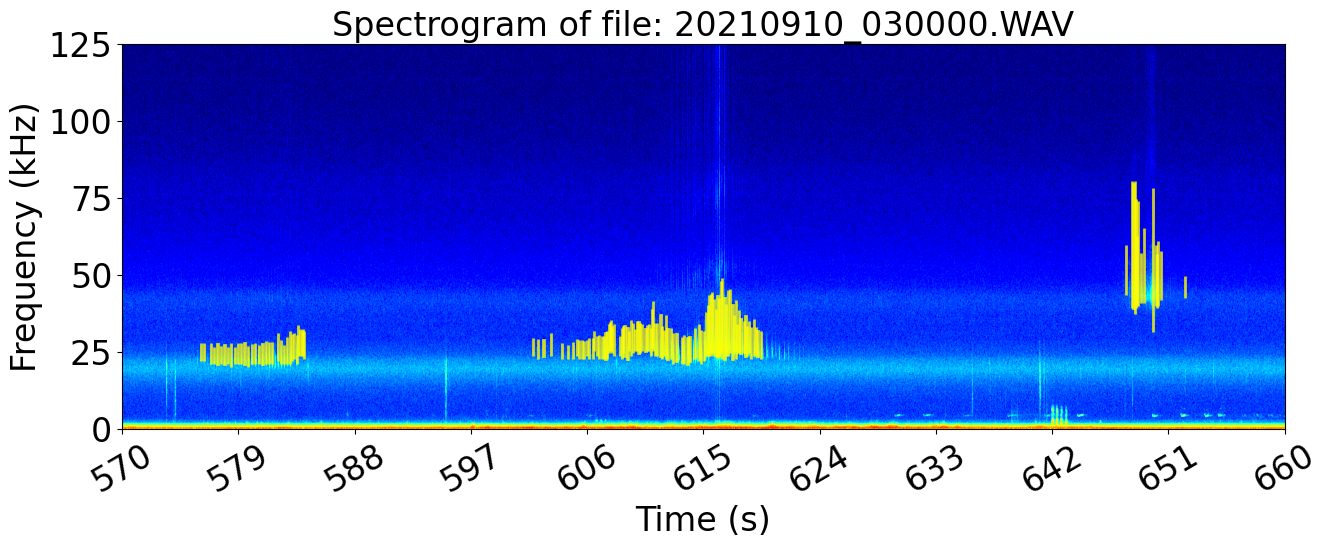

In [55]:
input_file1 = Path('../../Documents/Research/Lab_related/example/original_recording/recover-20210912_unit2/UBNA_002/20210910_030000.WAV')

cfg = get_config()
cfg['input_audio'] = Path(input_file1)
cfg['tmp_dir'] = Path('../output/tmp')
cfg['output_dir'] = Path('../output_dir/recover-20210912/Foliage/')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = False

filename = input_file1.name.split('.')[0]
original_file_dets = pd.read_csv(f'../output_dir/recover-20210912/Foliage/bd2_{filename}.csv')
audio_data = sf.SoundFile(input_file1)
fs = audio_data.samplerate
start = 570
duration = 90
end = int(start+duration)
audio_data.seek(int(fs*start))
audio_seg = audio_data.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB
vmax = 20*np.log10(np.max(audio_seg)) + 0 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = input_file1
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax
spec_features['plot_title'] = f"Spectrogram of file: {audio_features['file_path'].name}"

window_cond = np.logical_and(original_file_dets['start_time'] > start, original_file_dets['end_time'] < (start+duration))
section_og_file_dets = original_file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, section_og_file_dets)

In [56]:
write_file = Path(f'../../Downloads/{filename}_sample.WAV')
sf.write(write_file, audio_seg, fs)
sample_file_dets = run_pipeline_on_file(write_file, cfg)

100%|██████████| 3/3 [00:26<00:00,  8.94s/it]


In [57]:
sample_file_dets

,KMEANS_CLASSES,peak_frequency,SNR,start_time,end_time,low_freq,high_freq,class,class_prob,det_prob,individual,event,sampling_rate,input_file
0,LF,23040.0,6.425928,6.0775,6.0975,22031,28001,Nyctalus noctula,0.274,0.534,-1,Echolocation,250000,../../Downloads/20210910_030000_sample.WAV
1,LF,23040.0,6.401419,6.3255,6.3450,22031,27840,Nyctalus noctula,0.263,0.506,-1,Echolocation,250000,../../Downloads/20210910_030000_sample.WAV
2,LF,22080.0,15.285162,6.8455,6.8660,21171,27836,Nyctalus noctula,0.479,0.644,-1,Echolocation,250000,../../Downloads/20210910_030000_sample.WAV
3,LF,23040.0,10.704931,7.1175,7.1392,21171,26839,Nyctalus noctula,0.328,0.544,-1,Echolocation,250000,../../Downloads/20210910_030000_sample.WAV
4,LF,22080.0,18.930796,7.3725,7.3933,21171,27665,Nyctalus noctula,0.340,0.583,-1,Echolocation,250000,../../Downloads/20210910_030000_sample.WAV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,HF,44160.0,26.232666,80.0245,80.0301,40078,59718,Pipistrellus nathusii,0.251,0.538,-1,Echolocation,250000,../../Downloads/20210910_030000_sample.WAV
11,HF,43200.0,18.088464,80.1075,80.1131,39218,56991,Myotis daubentonii,0.236,0.530,-1,Echolocation,250000,../../Downloads/20210910_030000_sample.WAV
12,HF,43200.0,19.092728,80.1995,80.2054,40078,60964,Pipistrellus nathusii,0.241,0.553,-1,Echolocation,250000,../../Downloads/20210910_030000_sample.WAV
13,HF,44160.0,11.031999,80.3925,80.3979,41796,57959,Myotis daubentonii,0.181,0.505,-1,Echolocation,250000,../../Downloads/20210910_030000_sample.WAV


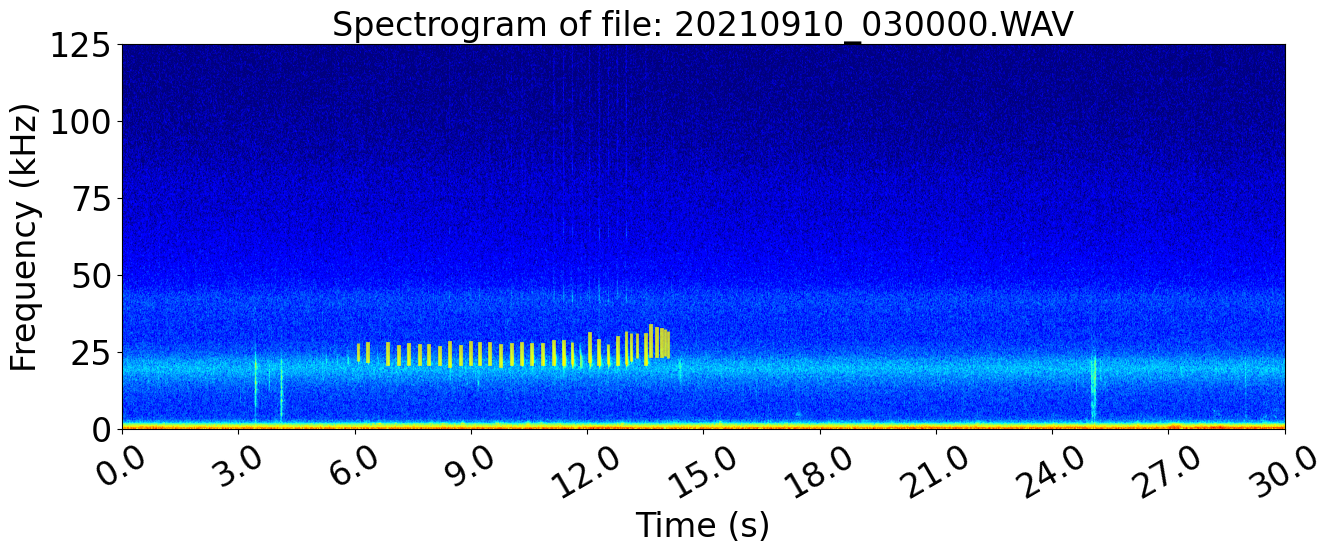

In [38]:
cfg = get_config()
cfg['input_audio'] = Path(write_file)
cfg['tmp_dir'] = Path('../output/tmp')
cfg['output_dir'] = Path('../output_dir')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = False

audio_data = sf.SoundFile(write_file)
fs = audio_data.samplerate
start = 0
duration = 30
end = int(start+duration)
audio_data.seek(int(fs*start))
audio_seg = audio_data.read(int(fs*duration))

audio_features = dict()
audio_features['file_path'] = write_file
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

plot_dets_over_audio(audio_features, spec_features, sample_file_dets)

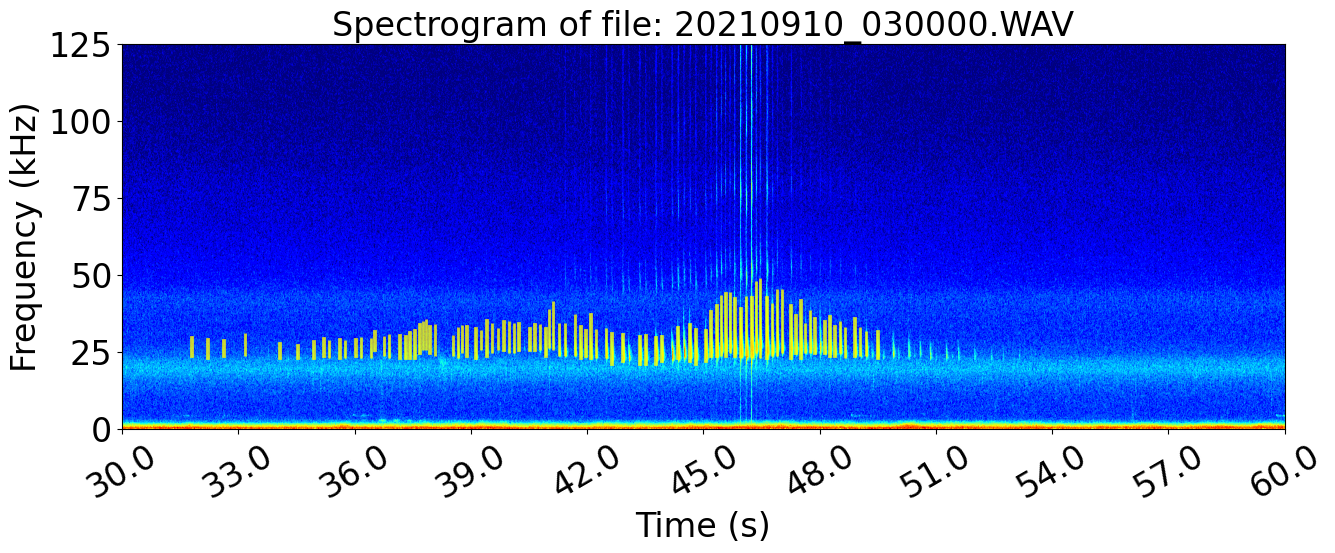

In [37]:
cfg = get_config()
cfg['input_audio'] = Path(write_file)
cfg['tmp_dir'] = Path('../output/tmp')
cfg['output_dir'] = Path('../output_dir')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = False

audio_data = sf.SoundFile(write_file)
fs = audio_data.samplerate
start = 30
duration = 30
end = int(start+duration)
audio_data.seek(int(fs*start))
audio_seg = audio_data.read(int(fs*duration))

audio_features = dict()
audio_features['file_path'] = write_file
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

plot_dets_over_audio(audio_features, spec_features, sample_file_dets)

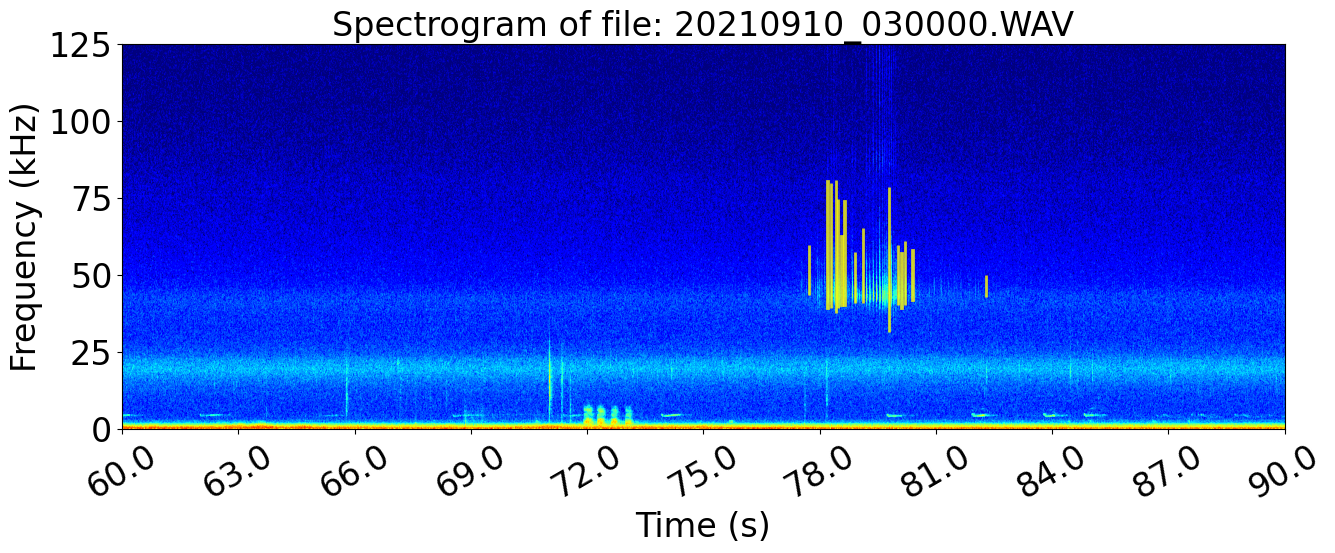

In [39]:
cfg = get_config()
cfg['input_audio'] = Path(write_file)
cfg['tmp_dir'] = Path('../output/tmp')
cfg['output_dir'] = Path('../output_dir')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = False

audio_data = sf.SoundFile(write_file)
fs = audio_data.samplerate
start = 60
duration = 30
end = int(start+duration)
audio_data.seek(int(fs*start))
audio_seg = audio_data.read(int(fs*duration))

audio_features = dict()
audio_features['file_path'] = write_file
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

plot_dets_over_audio(audio_features, spec_features, sample_file_dets)